In [3]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import r2_score
%matplotlib inline

## Задание 2

Реализуйте произведение матриц $A\in Mat(N\times K)$, $B\in Mat(K\times M)$ согласно определению
$$
C_{n,m}=\sum_{k=1}^K A_{n,k}B_{k,m}.
$$
Сравните быстродействие реализаций на основе numpy.sum, с помощью numba и стандартный метод numpy.dot.
Насколько полно используется процессор? 
Сколько используется памяти?

In [4]:
def no_nb_matmul(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for m in range(num_cols2):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for m in range(num_cols2):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

@nb.njit('float64(float64[:],float64[:])', parallel = False) # 2D-arrays
def nb_vecmul(in_vec1: np.ndarray, in_vec2: np.ndarray) -> np.ndarray:
    num_elem = in_vec1.shape[0]
    out = 0
    for n in range(num_elem):
        out += in_vec1[n]*in_vec2[n]
    return out

def sum_matmul(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    out_mtrx = np.empty(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for m in range(num_cols2):
            out_mtrx[n, m] = np.sum(in_mtrx1[n, :]*in_mtrx2[:, m])
    return out_mtrx

In [5]:
# generate input data
np.random.seed(0)
num_repetitions = 5

num_rows1 = 10
num_cols2 = 10
num_cols1 = 1000

mtrx1 = np.random.random(size=(num_rows1, num_cols1))
mtrx2 = np.random.random(size=(num_cols1, num_cols2))

vec1 = np.random.random(size=(1, num_cols1))
vec2 = np.random.random(size=(num_cols1, 1))

vec1_f = vec1.flatten()
vec2_f = vec2.flatten()

In [6]:
print("Matrix multiplication:")
print("Numba matmul:")
%timeit nb_matmul(mtrx1, mtrx2)
print("Numpy matmul:")
%timeit np.matmul(mtrx1, mtrx2)
print("Numpy sum matmul:")
%timeit sum_matmul(mtrx1, mtrx2)
print()

print("Vector multiplication:")
print("Numba matmul:")
%timeit nb_matmul(vec1, vec2)
print("Numba vecmul:")
%timeit nb_vecmul(vec1_f, vec2_f)
print("Numpy matmul (not flatten):")
%timeit np.matmul(vec1, vec2)
print("Numpy matmul (with flatten):")
%timeit np.matmul(vec1_f, vec2_f)
print("Numpy sum matmul:")
%timeit sum_matmul(vec1, vec2)

Matrix multiplication:
Numba matmul:
113 μs ± 24.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Numpy matmul:
18.9 μs ± 135 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Numpy sum matmul:
619 μs ± 8.85 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Vector multiplication:
Numba matmul:
1.89 μs ± 75.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
Numba vecmul:
1.18 μs ± 9.71 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
Numpy matmul (not flatten):
1.67 μs ± 32.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
Numpy matmul (with flatten):
1.61 μs ± 23.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
Numpy sum matmul:
6.46 μs ± 165 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Из приведенных выше оценок времени выполнения матричного умножения разными алгоритмами можно сделать следующие выводы:
- В случае перемножения двумерных массивов (матриц) реализация умножения через `np.sum` сильно проигрывает стандартному матричному умножению в `numpy` и реализации через `numba.jit`. Умножение, реализованное в `numpy` выполняется быстрее, т. к., вероятнее всего используется разбиение матриц на блоки и перемножение происходит поблоково. Это позволяет использовать кэш по-максимому (т. к. значения в кэш считывабтся не по-одиночке, а страницей).
- Предположение, сделанное выше можно проверить перемножением матриц (векторов) с размерами $1\times K$ и $K\times 1$. Видно, что результат `nb_matmul` и `np.matmul` почти одинаковый. Отличие может возникать из-за того, что перемножаемые массивы остались двумерными. Также реализация умножения векторов с приведением к одному измерению (flatten) дает более быстрый результат.

Использование процессора можно было посмотреть с помощью библиотеки `psutil`, но результаты сильно различаются от запуска к запуску и сильно зависят от работающих фоном приложений.

## Задание 3

Составьте модель использования вычислительных ресурсов функцией на основе numba.jit из предыдущего пункта.
Размеры матриц должны быть параметрами модели.
Проведите вычислительные эксперименты, чтобы подобрать параметры модели.
Экстраполируйте результат на большие матрицы, сделайте экспериментальную проверку.

Мы рассматриваем матрицы $A\in Mat(N\times K)$, $B\in Mat(K\times M)$. Исследуем зависимость времени выполнения от размера $K$ ($M$ и $N$ - фиксированы). Ожидаемую сложность выполнения программы можно представить так:
$$T(K)=aK+b$$
- $b$ не зависит от размера $K$, можно назвать его временем на запуск
- Считывание строки матрицы $A$ делается за $O(K)$
- Считывание столбца матрицы $B$ делается за $O(K)$
- Произведение $K$ пар элементов и их суммирование за $O(K)$
Константа перед переменной размера $K$ зависит от $M$ и $N$, тк это делается $MN$ раз.

In [7]:
# changing k-size
def get_runtime_vs_ksize(varying_size_k, func, num_rows1=10, num_cols2=10, num_repetitions=10):
    num_cols1 = varying_size_k[-1]

    mtrx1 = np.random.random(size=(num_rows1, num_cols1))
    mtrx2 = np.random.random(size=(num_cols1, num_cols2))

    ksize_time = np.empty_like(varying_size_k, dtype=np.float64)

    for i, sz in enumerate(varying_size_k):
        ksize_time[i] = timeit.timeit(stmt='my_matmul(mtrx1, mtrx2)',
                                    globals={"my_matmul": func, "mtrx1": mtrx1[:,:sz], "mtrx2": mtrx2[:sz,:]}, number=num_repetitions)
    return ksize_time

# changing n-size
def get_runtime_vs_nsize(varying_size_n, func, num_cols2=10, num_cols1=10):
    num_rows1 = varying_size_n[-1]

    mtrx1 = np.random.random(size=(num_rows1, num_cols1))
    mtrx2 = np.random.random(size=(num_cols1, num_cols2))

    nsize_time = np.empty_like(varying_size_n, dtype=np.float64)

    for i, sz in enumerate(varying_size_n):
        nsize_time[i] = timeit.timeit(stmt='my_matmul(mtrx1, mtrx2)',
                                    globals={"my_matmul": func, "mtrx1": mtrx1[:sz,:], "mtrx2": mtrx2}, number=10)
    return nsize_time

# changing m-size
def get_runtime_vs_msize(varying_size_m, func, num_rows1=10, num_cols1=10):
    num_cols2 = varying_size_m[-1]

    mtrx1 = np.random.random(size=(num_rows1, num_cols1))
    mtrx2 = np.random.random(size=(num_cols1, num_cols2))

    msize_time = np.empty_like(varying_size_m, dtype=np.float64)

    for i, sz in enumerate(varying_size_m):
        msize_time[i] = timeit.timeit(stmt='my_matmul(mtrx1, mtrx2)',
                                    globals={"my_matmul": func, "mtrx1": mtrx1, "mtrx2": mtrx2[:,:sz]}, number=10)
    return msize_time

In [8]:
varying_size_k = np.logspace(1, 3, 100, dtype=np.int32)
ksize_time_numba= get_runtime_vs_ksize(varying_size_k, func=nb_matmul)
ksize_time_numpy = get_runtime_vs_ksize(varying_size_k, func=np.dot)
ksize_time_sum = get_runtime_vs_ksize(varying_size_k, func=sum_matmul)

varying_size_n_and_m = np.logspace(1, 3, 5, dtype=np.int32)
nsize_time_numba= get_runtime_vs_nsize(varying_size_n_and_m, func=nb_matmul)
nsize_time_numpy = get_runtime_vs_nsize(varying_size_n_and_m, func=np.dot)
nsize_time_sum = get_runtime_vs_nsize(varying_size_n_and_m, func=sum_matmul)
msize_time_numba= get_runtime_vs_msize(varying_size_n_and_m, func=nb_matmul)
msize_time_numpy = get_runtime_vs_msize(varying_size_n_and_m, func=np.dot)
msize_time_sum = get_runtime_vs_msize(varying_size_n_and_m, func=sum_matmul)

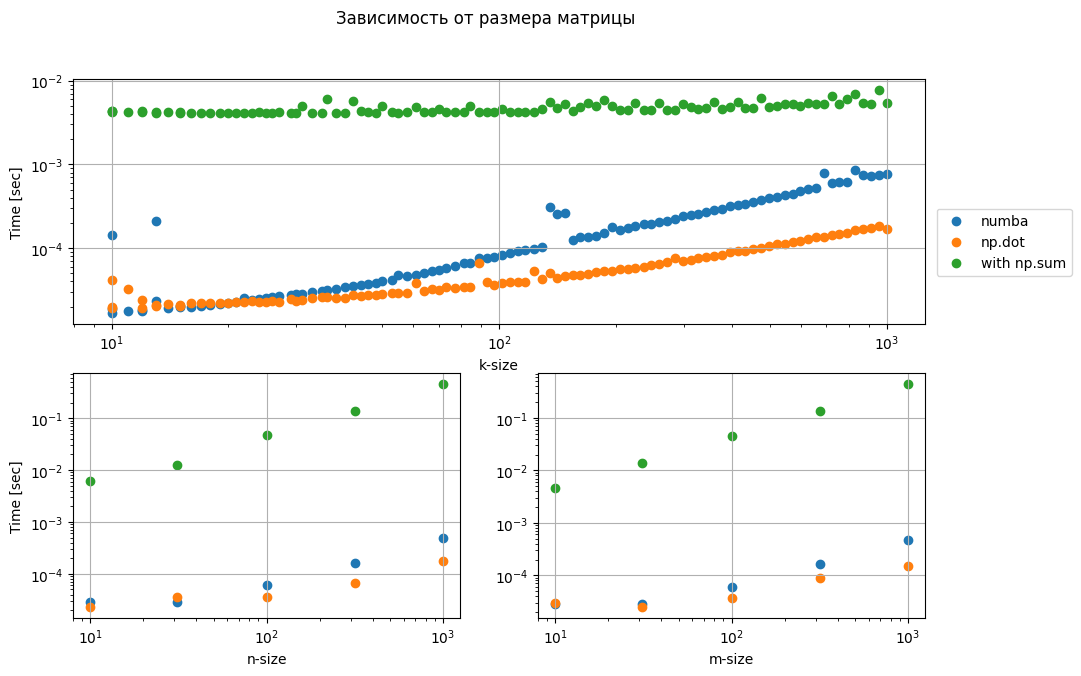

In [9]:
fig1 = plt.figure(figsize=[11,7])
fig1.suptitle(r'Зависимость от размера матрицы')

ax_1 = fig1.add_subplot(211)
ax_1.scatter(varying_size_k, ksize_time_numba, label="numba")
ax_1.scatter(varying_size_k, ksize_time_numpy, label="np.dot")
ax_1.scatter(varying_size_k, ksize_time_sum, label="with np.sum")
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend(bbox_to_anchor=(1.18, 0.5))
ax_1.grid()

ax_2 = fig1.add_subplot(223)
ax_2.scatter(varying_size_n_and_m, nsize_time_numba, label="numba")
ax_2.scatter(varying_size_n_and_m, nsize_time_numpy, label="np.dot")
ax_2.scatter(varying_size_n_and_m, nsize_time_sum, label="with np.sum")
ax_2.set_xlabel('n-size')
ax_2.set_ylabel('Time [sec]')
ax_2.set_xscale('log')
ax_2.set_yscale('log')
ax_2.grid()

ax_3 = fig1.add_subplot(224)
ax_3.scatter(varying_size_n_and_m, msize_time_numba, label="numba")
ax_3.scatter(varying_size_n_and_m, msize_time_numpy, label="np.dot")
ax_3.scatter(varying_size_n_and_m, msize_time_sum, label="with np.sum")
ax_3.set_xlabel('m-size')
ax_3.set_xscale('log')
ax_3.set_yscale('log')
ax_3.grid()

plt.show()

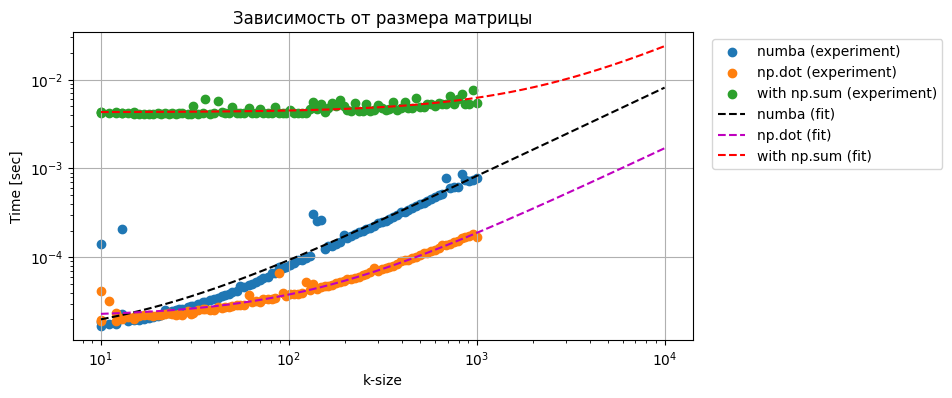

In [10]:
numba_fit_coeffs = np.polyfit(varying_size_k, ksize_time_numba, 1)
numpy_fit_coeffs = np.polyfit(varying_size_k, ksize_time_numpy, 1)
sum_fit_coeffs = np.polyfit(varying_size_k, ksize_time_sum, 1)

numba_poly = np.poly1d(numba_fit_coeffs)
numpy_poly = np.poly1d(numpy_fit_coeffs)
sum_poly = np.poly1d(sum_fit_coeffs)

ksize_for_plot = np.logspace(1, 4, 1000)


fig2 = plt.figure(figsize=[8,4])
ax_1 = fig2.add_subplot(111)
ax_1.set_title(r'Зависимость от размера матрицы')
ax_1.scatter(varying_size_k, ksize_time_numba, label="numba (experiment)")
ax_1.scatter(varying_size_k, ksize_time_numpy, label="np.dot (experiment)")
ax_1.scatter(varying_size_k, ksize_time_sum, label="with np.sum (experiment)")
ax_1.plot(ksize_for_plot, numba_poly(ksize_for_plot), "k--", label="numba (fit)")
ax_1.plot(ksize_for_plot, numpy_poly(ksize_for_plot), "m--", label="np.dot (fit)")
ax_1.plot(ksize_for_plot, sum_poly(ksize_for_plot), "r--",label="with np.sum (fit)")
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend(bbox_to_anchor=(1.02, 1))
ax_1.grid()
plt.show()

Проверим точность экстраполяции

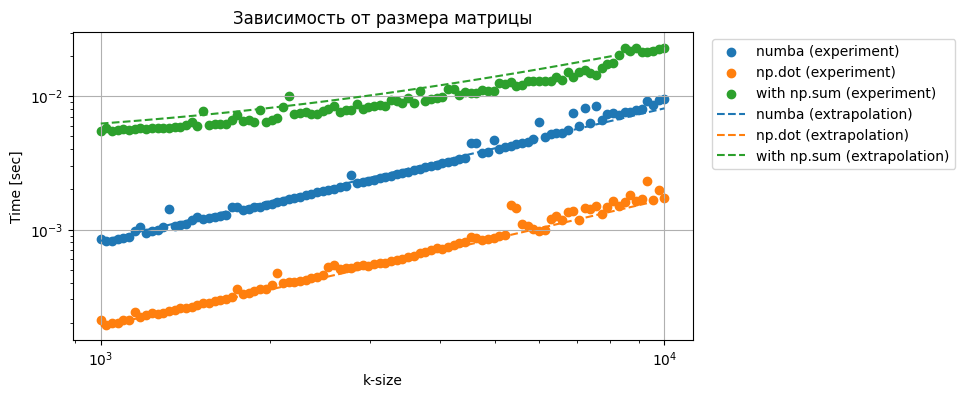

In [66]:
big_ksize = np.logspace(3, 4, 100, dtype=np.int32)
bigksize_time_numba = get_runtime_vs_ksize(big_ksize, func=nb_matmul)
bigksize_time_numpy = get_runtime_vs_ksize(big_ksize, func=np.dot)
bigksize_time_sum = get_runtime_vs_ksize(big_ksize, func=sum_matmul)

ksize_for_plot = np.logspace(3, 4, 300)

# for i in range(len(big_ksize)):
#     print("Results K="+str(big_ksize[i]))
#     print("Numba: Experiment = {} sec, Theory = {} sec".format(bigksize_time_numba[i], numba_poly(big_ksize[i])))
#     print("Numpy: Experiment = {} sec, Theory = {} sec".format(bigksize_time_numpy[i], numpy_poly(big_ksize[i])))
#     print("Sum: Experiment = {} sec, Theory = {} sec".format(bigksize_time_sum[i], sum_poly(big_ksize[i])))

fig3 = plt.figure(figsize=[8,4])
ax_1 = fig3.add_subplot(111)
ax_1.set_title(r'Зависимость от размера матрицы')
ax_1.scatter(big_ksize, bigksize_time_numba, label="numba (experiment)")
ax_1.scatter(big_ksize, bigksize_time_numpy, label="np.dot (experiment)")
ax_1.scatter(big_ksize, bigksize_time_sum, label="with np.sum (experiment)")
ax_1.plot(big_ksize, numba_poly(big_ksize), "--", label="numba (extrapolation)")
ax_1.plot(big_ksize, numpy_poly(big_ksize), "--", label="np.dot (extrapolation)")
ax_1.plot(big_ksize, sum_poly(big_ksize), "--",label="with np.sum (extrapolation)")
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend(bbox_to_anchor=(1.02, 1))
ax_1.grid()
plt.show()

In [67]:
r2_numba = r2_score(y_true=bigksize_time_numba, y_pred=numba_poly(big_ksize))
r2_numpy = r2_score(y_true=bigksize_time_numpy, y_pred=numpy_poly(big_ksize))
r2_sum = r2_score(y_true=bigksize_time_sum, y_pred=sum_poly(big_ksize))
print("R^2 [numba]: ", r2_numba)
print("R^2 [numpy]: ", r2_numpy)
print("R^2 [sum]: ", r2_sum)

R^2 [numba]:  0.9492692536001144
R^2 [numpy]:  0.9217455462024687
R^2 [sum]:  0.8387748552781034


Из полученных результатов можно сделать вывод, что модель, использованную для оценки времени выполнения матричного умножения можно использовать для предсказания времени выполнения, т. к. метрика $R^2$ близка к значению 0.9. Но при увеличении размера матрицы, в один момент будет превышен лимит кэша и время вполнения приобретет смещение (изменится константа $b$) и незначительно увеличивается наклон прямой. Пример приведен ниже:

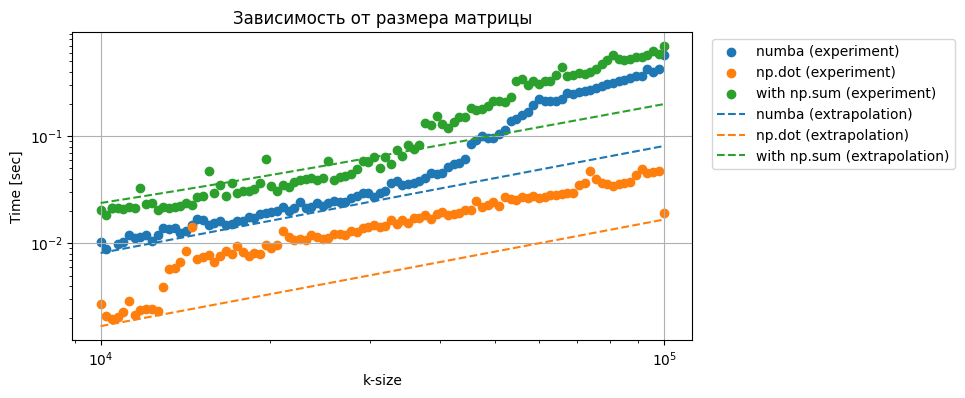

In [13]:
new_big_ksize = np.logspace(4, 5, 100, dtype=np.int32)
new_bigksize_time_numba = get_runtime_vs_ksize(new_big_ksize, func=nb_matmul)
new_bigksize_time_numpy = get_runtime_vs_ksize(new_big_ksize, func=np.dot)
new_bigksize_time_sum = get_runtime_vs_ksize(new_big_ksize, func=sum_matmul)

fig3_5 = plt.figure(figsize=[8,4])
ax_1 = fig3_5.add_subplot(111)
ax_1.set_title(r'Зависимость от размера матрицы')
ax_1.scatter(new_big_ksize, new_bigksize_time_numba, label="numba (experiment)")
ax_1.scatter(new_big_ksize, new_bigksize_time_numpy, label="np.dot (experiment)")
ax_1.scatter(new_big_ksize, new_bigksize_time_sum, label="with np.sum (experiment)")
ax_1.plot(new_big_ksize, numba_poly(new_big_ksize), "--", label="numba (extrapolation)")
ax_1.plot(new_big_ksize, numpy_poly(new_big_ksize), "--", label="np.dot (extrapolation)")
ax_1.plot(new_big_ksize, sum_poly(new_big_ksize), "--",label="with np.sum (extrapolation)")
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend(bbox_to_anchor=(1.02, 1))
ax_1.grid()
plt.show()

Поэтому, возможно, применить к большим размерам полученную на маленьких размерах оценку для времени выполнения в полной мере не получится. Но можно оценить скорости роста времени выполнения каждого метода (и таким образом их сравнить):

In [14]:
print("Numba coeff. a: ", numba_fit_coeffs[0])
print("Numpy coeff. a: ", numpy_fit_coeffs[0])
print("Sum coeff. a: ", sum_fit_coeffs[0])

Numba coeff. a:  8.113343997387292e-07
Numpy coeff. a:  1.6678426897825165e-07
Sum coeff. a:  1.953196726422859e-06


Видно, что время выполнения `np.dot` растет почти на порядок медленнее.

## Задание 4

В простейшем алгоритме произведения матриц используются три цикла: перебирающие элементы $n$ и $m$  матрицы $C$
и суммирующие по $k$. 
Сравните время перемножения матриц в зависимости от порядка циклов.
Оцените объем кэшей разных уровней, проводя эксперименты для матриц разного размера.

Сравнить время уножения матриц в зависимости от порядка циклов

In [15]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul_nmk(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for m in range(num_cols2):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul_nkm(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in range(num_rows1):
        for k in range(num_cols1):
            for m in range(num_cols2):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul_knm(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for k in range(num_cols1):
        for n in range(num_rows1):
            for m in range(num_cols2):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = False) # 2D-arrays
def nb_matmul_mnk(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    # num_rows2, num_cols2 = in_mtrx2.shape
    # assert (num_cols1 == num_rows2, "Incorrect input matrices sizes")
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for m in range(num_cols2):
        for n in range(num_rows1):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

In [16]:
k_sweep = np.logspace(2, 4, 100, dtype=np.int32)

nmk_time = get_runtime_vs_ksize(k_sweep, func=nb_matmul_nmk)
nkm_time = get_runtime_vs_ksize(k_sweep, func=nb_matmul_nkm)
knm_time = get_runtime_vs_ksize(k_sweep, func=nb_matmul_knm)
mnk_time = get_runtime_vs_ksize(k_sweep, func=nb_matmul_mnk)

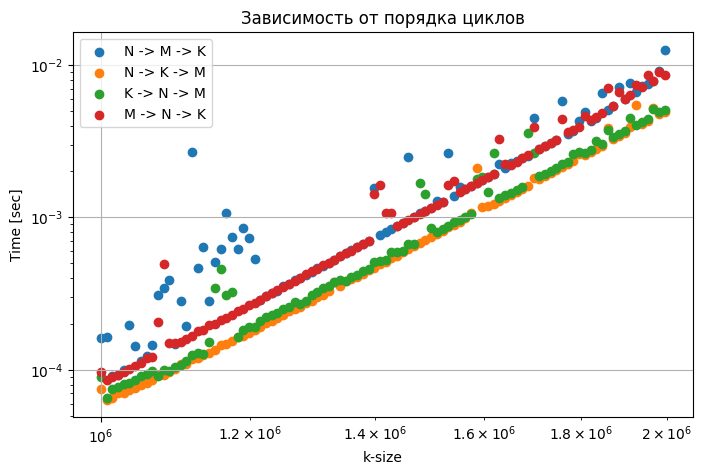

In [62]:
fig4 = plt.figure(figsize=[8,5])
ax_1 = fig4.add_subplot(111)
ax_1.set_title(r'Зависимость от порядка циклов')
ax_1.scatter(k_sweep, nmk_time, label="N -> M -> K")
ax_1.scatter(k_sweep, nkm_time, label="N -> K -> M")
ax_1.scatter(k_sweep, knm_time, label="K -> N -> M")
ax_1.scatter(k_sweep, mnk_time, label="M -> N -> K")
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend()
ax_1.grid()
plt.show()

Видно, что алгоритмы, в которых цикл по направлению, по которому идет суммирование ($K$) не самым последним циклом выполняется быстрее в несколько раз (около 2).

Теперь оценим объем кэша.
Ожидается, что, когда размер матрицы будет пересекать значение, равное размеру кэша определенного уровня, будет происходить скачкообразное увеличение времени выполнения.

Чтобы убедиться, что мы попадем в эти точки, возьмем истинные значения памяти кэша:

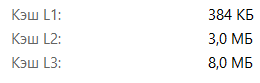

Расчитаем, какой размер $K$ должен быть у матрицы, чтоб достичь размера кэша:
- Элементы матрицы -- числа float64. Занимают 8 байт каждое.
- Чтобы примерно достичь размера кэша L1 нужно взять $K_1 = 384*1024/8 \approx 49152$
- Чтобы примерно достичь размера кэша L2 нужно взять $K_2 = K_1 +  3*1024^2/8\approx 442368$
- Чтобы примерно достичь размера кэша L3 нужно взять $K_3 = K_2 +  8*1024^2/8\approx 1490944$

Чтобы легче было сопоставлять размер кэша и размер матрицы возьмем $N=M=1$

In [18]:
k_sweep_l1 = np.arange(10000, 70000, 500, dtype=np.int32)
# k_sweep_l1 = np.arange(100000, 1000000, 100, dtype=np.int32)
l1_time = get_runtime_vs_ksize(k_sweep_l1, func=nb_matmul, num_rows1=1, num_cols2=1, num_repetitions=5000)

In [19]:
k_sweep_l2 = np.arange(270000, 470000, 2000, dtype=np.int32)
l2_time = get_runtime_vs_ksize(k_sweep_l2, func=nb_matmul, num_rows1=1, num_cols2=1, num_repetitions=500)

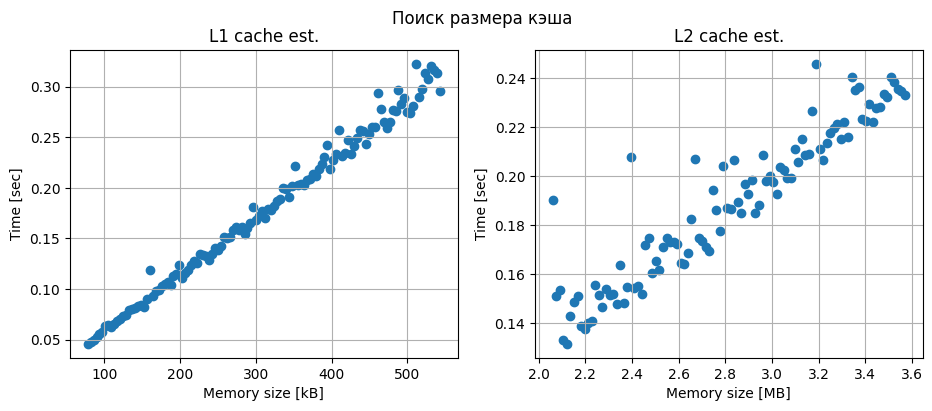

In [20]:
fig5 = plt.figure(figsize=[11,4])
fig5.suptitle(r'Поиск размера кэша')

ax_1 = fig5.add_subplot(121)
ax_1.set_title('L1 cache est.')
ax_1.scatter(k_sweep_l1*8/1024, l1_time)
# ax_1.set_xlabel('k-size')
ax_1.set_xlabel('Memory size [kB]')
ax_1.set_ylabel('Time [sec]')
ax_1.grid()

ax_2 = fig5.add_subplot(122)
ax_2.set_title('L2 cache est.')
ax_2.scatter(k_sweep_l2*8/1024**2, l2_time)
ax_2.set_xlabel('Memory size [MB]')
ax_2.set_ylabel('Time [sec]')
ax_2.grid()

plt.show()

Не получилось увидеть резких скачков времени выполнения на векторах. Попробуем оценить суммарный размер кэша. Из выкладок выше, суммарный объем кэша вмещает $1982464$, т.е. $(\approx 10^6)$ 64-битных значений. Суммарный объем кэша: 11.3 МБ.

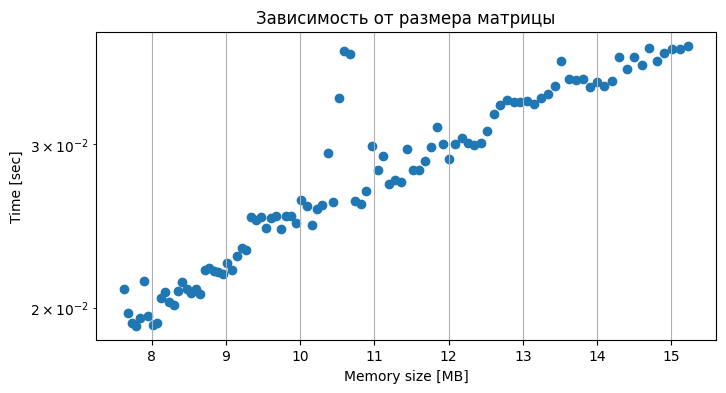

In [59]:
k_sweep = np.logspace(6, 6.3, 100, dtype=np.int32)
cache_time = get_runtime_vs_ksize(k_sweep, func=nb_matmul, num_rows1=1, num_cols2=1, num_repetitions=20)

fig5_5 = plt.figure(figsize=[8,4])
ax_1 = fig5_5.add_subplot(111)
ax_1.set_title(r'Зависимость от размера матрицы')
ax_1.scatter(k_sweep*8/1024**2, cache_time)
ax_1.set_xlabel('Memory size [MB]')
ax_1.set_ylabel('Time [sec]')
# ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.grid()
plt.show()

Специально оставили ось x в линейном масштабе, чтоб видеть значения размера матрицы в МБ. Видно, что при размере примерно 10 МБ есть некоторый скачок.

## Задание 5

Обновите функцию для перемножения матриц, используя несколько потоков с помощью numba.prange.
Обновите модель использования вычислительных ресурсов, принимая во внимание число потоков.
Оцените параметры модели из эксперимента.
Какое [параллельное ускорение](https://en.wikipedia.org/wiki/Amdahl%27s_law) вы получили?

In [22]:
@nb.njit('float64[:,:](float64[:,:],float64[:,:])', parallel = True, nogil = True) # 2D-arrays
def nb_matmul_parallel(in_mtrx1: np.ndarray, in_mtrx2: np.ndarray) -> np.ndarray:
    num_rows1, num_cols1 = in_mtrx1.shape
    num_cols2 = in_mtrx2.shape[1]
    out_mtrx = np.zeros(shape=(num_rows1, num_cols2), dtype=np.float64)
    for n in nb.prange(num_rows1):
        for m in range(num_cols2):
            for k in range(num_cols1):
                out_mtrx[n, m] += in_mtrx1[n, k]*in_mtrx2[k, m]
    return out_mtrx

In [23]:
def get_parallel_time_vs_threads(threads, num_rows1=1024, num_cols1=128, num_cols2=128, num_repetitions=10):
    mtrx1 = np.random.random(size=(num_rows1, num_cols1))
    mtrx2 = np.random.random(size=(num_cols1, num_cols2))

    par_time = np.empty_like(threads, dtype=np.float64)
    for i in range(len(threads)):
        nb.set_num_threads(threads[i])
        par_time[i] = timeit.timeit(stmt='my_matmul(mtrx1, mtrx2)', 
                                      globals={"my_matmul": nb_matmul_parallel, "mtrx1": mtrx1, "mtrx2": mtrx2},
                                      number=num_repetitions)
    return par_time

In [24]:
threads = np.arange(1, 7, 1, dtype=np.int32)
threads_par_time = get_parallel_time_vs_threads(threads)

# fit model (f(x) = aN/p + b), p - number of threads
par_coefs = np.polyfit(1/threads, threads_par_time, 1)
par_time_poly = np.poly1d(par_coefs)

threads_upsampled = np.linspace(1, 6, 100)
threads_upsampled_par_time = par_time_poly(1/threads_upsampled)
#print(par_time_poly)

parallel_speedup = threads_par_time[0]/threads_par_time
parallel_speedup_upsampled = threads_par_time[0] / threads_upsampled_par_time

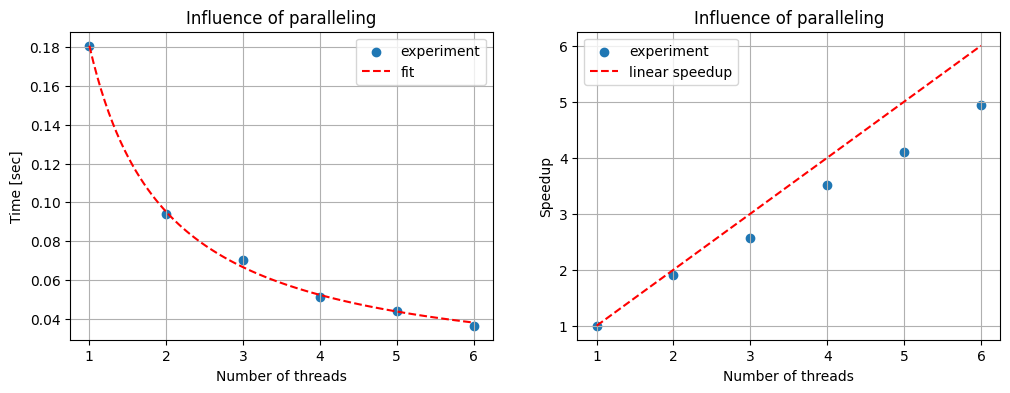

In [25]:
fig6 = plt.figure(figsize=[12,4])
ax_1 = fig6.add_subplot(121)
ax_1.set_title('Influence of paralleling')
ax_1.scatter(threads, threads_par_time, label='experiment')
ax_1.plot(threads_upsampled, threads_upsampled_par_time, 'r--', label='fit')
ax_1.set_xlabel('Number of threads')
ax_1.set_ylabel('Time [sec]')
ax_1.legend()
ax_1.grid()

ax_1 = fig6.add_subplot(122)
ax_1.set_title('Influence of paralleling')
ax_1.scatter(threads, parallel_speedup, label='experiment')
ax_1.plot(threads_upsampled, threads_upsampled, 'r--', label='linear speedup')
# ax_1.plot([1, 6], [par_coefs[0]/par_coefs[1] + 1, par_coefs[0]/par_coefs[1] + 1], 'm--', label='speedup limit')
ax_1.set_xlabel('Number of threads')
ax_1.set_ylabel('Speedup')
ax_1.legend()
ax_1.grid()

plt.show()

Мы распараллелили вычисления по $N$ строкам матиицы $A$. Простую модель времени вычислений можно записать так (сначала без параллелизма):

<!-- $$T_1 = \underbrace{\alpha N}_{\text{Включает арифметику, чтение и запись}} + \underbrace{\beta}_{время на запуск}$$ -->
$$T_1 = \alpha N + \beta$$
где $\alpha$ - коэффициент с учетом арифметики, чтения и записи, $\beta$ - время на запуск (то, что не зависит от размеров матрицы).

Распараллеливание на $p$ потоков позволяет уменьшить только первое слагаемое в этой сумме:

$$T_p = \alpha N / p + \beta$$

Также, можно определить ускорение, получаемое при использовании $p$ потоков вместо 1: $S_p=T_1/T_1$

С учетом используемой модели, видно, что добиться линейного ускорения ($S_p=p$) добиться не получится, значение ускорения упрется в предел:

$$\lim_p S_p = \dfrac{\alpha N + \beta}{\alpha N / p + \beta} = \dfrac{\alpha N}{\beta}+1$$
параметры $\alpha N$ и $\beta$ можно оценить из полученных результатов, применяя апроксимацию формулой для $T_p$ (см. график 1).

Теперь можно найти предельное значение параллельного ускорения.

In [26]:
speedup_lim = par_coefs[0] / par_coefs[1] + 1
print("Maximum parallel speedup (p->+inf): ", speedup_lim)

Maximum parallel speedup (p->+inf):  18.736509827203946


## Задание 7

Реализуйте быстрое произведение матриц, например, используйте [алгоритм Штрассена](https://en.wikipedia.org/wiki/Strassen_algorithm).
Оцените, на матрицах какого размера быстрое произведение матриц быстрее, чем стандартная реализация.
Какой из методов дает меньшую погрешность вычислений?

In [108]:
def strassen_matmul(A, B, base=16):
    n = len(A)
    if n <= base:
        return nb_matmul(A, B)
    else:
        A11, A12, A21, A22 = A[:n//2, :n//2], A[:n//2, n//2:], A[n//2:, :n//2], A[n//2:, n//2:]
        B11, B12, B21, B22 = B[:n//2, :n//2], B[:n//2, n//2:], B[n//2:, :n//2], B[n//2:, n//2:]

        M1 = strassen_matmul(A11 + A22, B11 + B22)
        M2 = strassen_matmul(A21 + A22, B11)
        M3 = strassen_matmul(A11, B12 - B22)
        M4 = strassen_matmul(A22, B21 - B11)
        M5 = strassen_matmul(A11 + A12, B22)
        M6 = strassen_matmul(A21 - A11, B11 + B12)
        M7 = strassen_matmul(A12 - A22, B21 + B22)

        C11 = M1 + M4 - M5 + M7
        C12 = M3 + M5
        C21 = M2 + M4
        C22 = M1 - M2 + M3 + M6

        return np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))

In [73]:
def get_runtime_vs_ksize_strassen(varying_size_k, func, num_repetitions=10):
    num_cols1 = varying_size_k[-1]

    mtrx1 = np.random.random(size=(num_cols1, num_cols1))
    mtrx2 = np.random.random(size=(num_cols1, num_cols1))

    ksize_time = np.empty_like(varying_size_k, dtype=np.float64)

    for i, sz in enumerate(varying_size_k):
        ksize_time[i] = timeit.timeit(stmt='my_matmul(mtrx1, mtrx2)',
                                    globals={"my_matmul": func, "mtrx1": mtrx1[:sz,:sz], "mtrx2": mtrx2[:sz,:sz]}, number=num_repetitions)
    return ksize_time

In [121]:
# k_sweep_strassen = np.logspace(1, 5, 100, dtype=np.int32)
# time_strassen = get_runtime_vs_ksize(k_sweep_strassen, func=strassen_matmul, num_repetitions=50)
# time_nb_matmul = get_runtime_vs_ksize(k_sweep_strassen, func=nb_matmul, num_repetitions=50)
new_k_sweep = 2**np.arange(3, 11)
# new_k_sweep = np.logspace(2, 4, 100, dtype=np.int32)
new_time_strassen = get_runtime_vs_ksize_strassen(new_k_sweep, func=strassen_matmul)
new_time_nb_matmul = get_runtime_vs_ksize_strassen(new_k_sweep, func=nb_matmul)
new_time_np_matmul = get_runtime_vs_ksize_strassen(new_k_sweep, func=np.matmul)

In [ ]:
# fig7 = plt.figure(figsize=[8,4])
# ax_1 = fig7.add_subplot(111)
# ax_1.set_title('Strassen algorithm')
# ax_1.scatter(k_sweep_strassen, time_strassen, label='Strassen')
# ax_1.scatter(k_sweep_strassen, time_nb_matmul, label='Numba matmul')
# ax_1.set_xlabel('k-size')
# ax_1.set_ylabel('Time [sec]')
# ax_1.set_xscale('log')
# ax_1.set_yscale('log')
# ax_1.legend()
# ax_1.grid()
# plt.show()

In [ ]:
# str_coeffs = np.polyfit(new_k_sweep, new_time_strassen, 1)
# str_time_poly = np.poly1d(str_coeffs)
# nb_coeffs = np.polyfit(new_k_sweep, new_time_nb_matmul, 1)
# nb_time_poly = np.poly1d(nb_coeffs)

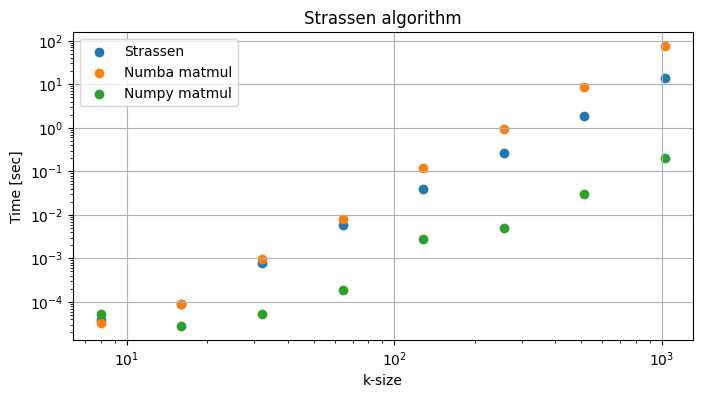

In [124]:
fig8 = plt.figure(figsize=[8,4])
ax_1 = fig8.add_subplot(111)
ax_1.set_title('Strassen algorithm')
ax_1.scatter(new_k_sweep, new_time_strassen, label='Strassen')
ax_1.scatter(new_k_sweep, new_time_nb_matmul, label='Numba matmul')
ax_1.scatter(new_k_sweep, new_time_np_matmul, label='Numpy matmul')
# ax_1.plot(new_k_sweep, str_time_poly(new_k_sweep), label='Strassen')
# ax_1.plot(new_k_sweep, nb_time_poly(new_k_sweep), label='Numba matmul')
ax_1.set_xlabel('k-size')
ax_1.set_ylabel('Time [sec]')
ax_1.set_xscale('log')
ax_1.set_yscale('log')
ax_1.legend()
ax_1.grid()
plt.show()

Получена зависимость времени работы наивного алгоритма `nb_matmul`, алгоритма из Numpy и алгоритма Штрассена для квадратных матриц, у которых размер равен степени двойки.

Видно, что алгоритм Штрассена начинает выигрывать у `nb_matmul` с довольно малых размеров матрицы.

Причем из полученных результатов нельзя сделать вывод об асимптотическом поведении все алгоритмов - наклон всех 3 кривых визуально одинаковый. Если еще увеличить размер матрицы, то вычисление времени выполнения уже будет происходить сильно долльше.

## Задания.

1. Изучите реализацию многомерных массивов numpy.ndarray и работу с ними в numba.
Посмотрите ноутбук [FastPython.](../FastPython.ipynb) 

2. Реализуйте произведение матриц $A\in Mat(N\times K)$, $B\in Mat(K\times M)$ согласно определению
$$
C_{n,m}=\sum_{k=1}^K A_{n,k}B_{k,m}.
$$
Сравните быстродействие реализаций на основе numpy.sum, с помощью numba и стандартный метод numpy.dot.
Насколько полно используется процессор? 
Сколько используется памяти?

3. Составьте модель использования вычислительных ресурсов функцией на основе numba.jit из предыдущего пункта.
Размеры матриц должны быть параметрами модели.
Проведите вычислительные эксперименты, чтобы подобрать параметры модели.
Экстраполируйте результат на большие матрицы, сделайте экспериментальную проверку.

4. В простейшем алгоритме произведения матриц используются три цикла: перебирающие элементы $n$ и $m$  матрицы $C$
и суммирующие по $k$. 
Сравните время перемножения матриц в зависимости от порядка циклов.
Оцените объем кэшей разных уровней, проводя эксперименты для матриц разного размера.

5. Обновите функцию для перемножения матриц, используя несколько потоков с помощью numba.prange.
Обновите модель использования вычислительных ресурсов, принимая во внимание число потоков.
Оцените параметры модели из эксперимента.
Какое [параллельное ускорение](https://en.wikipedia.org/wiki/Amdahl%27s_law) вы получили?

6. Сможете ли вы реализовать реализовать на С более быстрый вариант перемножения матриц, чем на numba?

7. Реализуйте быстрое произведение матриц, например, используйте [алгоритм Штрассена](https://en.wikipedia.org/wiki/Strassen_algorithm).
Оцените, на матрицах какого размера быстрое произведение матриц быстрее, чем стандартная реализация.
Какой из методов дает меньшую погрешность вычислений?


# Дополнительные задания

1. Реализуйте вычисление матрицы дискретизованного конечными разностями оператора Лапласа:
$$
Lf_{n,k}=4f_{n,k}-f_{n+1,k}-f_{n-1,k}-f_{n,k+1}-f_{n,k-1}.
$$

Функция $f$ задана на квадратной решетке своими значениями в узлах $f_{n,k}$, $n=0\ldots N$, $k=0\ldots K$.
Мы будем предполагать периодические граничные условия, в этом случае арифметические операции над индексом $n$ выполняются по модулю $N$, а по индексу $k$ по модулю $K$.
Хотя значения функции и хранятся в двухмерном массиве, с точки зрения матричных вычислений значения функции $f$ в узлах образуют вектор, а оператор $L$ действует на него умножением на матрицу.
Если нас смущает двойной индекс $(n,k)$ у $f$, то мы можем держать в голове, что это просто удобное обозначение для одного числа $n*K+k$, показывающего, в какой ячейке памяти хранится коэффициент вектора.
Оператор $L$ может быть задан своей матрицей:
$$
Lf_{n,k}=\sum_{n',k'}L_{n,k,n',k'} f_{n',k'},
$$
где $(n,k)$ - номер строки матрицы, а $(n',k')$ - номер столбца. 
Двойные индексы можно свернуть снова в обычные числа, тогда матрица будем иметь два индекса (строки и столбец), как нам более привычно. 
Однако, использование двойных индексов позволяет нам записать матрицу в очень простом виде:
$$
L_{n,k,n',k'}=
\begin{cases}
4, & n=n'\text{ и }k=k',\\
-1, & n=n'\pm 1\text{ и }k=k'\text{ или }n=n'\text{ и }k=k'\pm1,\\
0, & \text{в остальных случаях}. 
\end{cases}
$$

2. Матрица $L$ [разреженная](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D1%80%D0%B5%D0%B6%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0), т.е. большинство ее элементов равно нулю. 
Сохраните матрицу $L$ в виде разреженной матрицы из пакета [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html).
Какой способ хранения разреженной матрицы подходит лучше всего для матрицы оператора Лапласа?
Какими преимуществами обладает представление матрицы в разреженном виде?

3. Выше приведена формула для вычисления матрицы $L$ на векторах $f$, которая может быть реализована в виде алгоритма более быстрого, чем умножение на произвольню матрицу. Реализуйте функцию, которая будет вычислять произведение $L$ на $f$ без явного использования матрицы $L$. Воспользуйтесь [numpy](https://numpy.org/), постарайтесь реализовать как можно более быстрый код. Сравните полученное быстродействие с максимальной производительностью процессора вашего компьютера, согласно спецификации. 

4. Перепишите функцию из предыдущего задания, используя [numba](https://numba.pydata.org/). Какое ускорение мы можем ожидать, за счет чего оно достигается? Реализуйте наиболее эффективный код, учитывая аппаратные особенности компьютера. Убедитесь, что производительность вашего кода выше, чем умножение на разреженную матрицу, полученную выше. Как близко вы подобрались к пиковой теоретической производительности вашего компьютера?

# Литература

1. Ван Лоун Чарльз Ф., Голуб Джин Х. Матричные вычисления. Глава 1.

1. [NumPy](https://numpy.org/doc/stable/contents.html)

1. [Numba: A High Performance Python Compiler.](https://numba.pydata.org/) [Performance Tips](https://numba.pydata.org/numba-doc/latest/user/performance-tips.html)

1. [JAX: Autograd and XLA](https://github.com/google/jax)

1. [xeus-cling: a Jupyter kernel for C++](https://github.com/jupyter-xeus/xeus-cling)

1. [Minimal C kernel for Jupyter](https://github.com/brendan-rius/jupyter-c-kernel)

1. Micha Gorelick, Ian Ozsvald.
[High Performance Python](https://www.oreilly.com/library/view/high-performance-python/9781449361747/) 

1. [Performance Tips of NumPy ndarray](https://shihchinw.github.io/2019/03/performance-tips-of-numpy-ndarray.html)

1. [Beating NumPy performance speed by extending Python with C](https://medium.com/analytics-vidhya/beating-numpy-performance-by-extending-python-with-c-c9b644ee2ca8)

1. [Principles of Performance](https://llllllllll.github.io/principles-of-performance/index.html)